<a href="https://colab.research.google.com/github/kuds/rl-car-racing/blob/main/%5BCar%20Racing%5D%20Proximal%20Policy%20Optimization%20(PPO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install swig

In [2]:
!pip install gymnasium gymnasium[box2d] stable_baselines3 rl_zoo3

In [3]:
import gymnasium

import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecFrameStack, VecVideoRecorder
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.vec_env import VecTransposeImage
from stable_baselines3.common.evaluation import evaluate_policy

import platform
import IPython
import scipy
import numpy
import rl_zoo3
import torch
import time
torch.backends.cudnn.benchmark = True

In [4]:
print("Python Version: {}".format(platform.python_version()))
print("Is Cuda Available: {}".format(torch.cuda.is_available()))
print("Torch Version: {}".format(torch.__version__))
print("Cuda Version: {}".format(torch.version.cuda))
print("Scipy Version: {}".format(scipy.__version__))
print("Numpy Version: {}".format(numpy.__version__))
print("Stable Baseline Version: {}".format(stable_baselines3.__version__))
print("RL Zoo Version: {}".format(rl_zoo3.__version__))
print("IPython Version: {}".format(IPython.__version__))
print("Gymnasium Version: {}".format(gymnasium.__version__))

Python Version: 3.10.12
Is Cuda Available: True
Torch Version: 2.3.1+cu121
Cuda Version: 12.1
Scipy Version: 1.13.1
Numpy Version: 1.26.4
Stable Baseline Version: 2.3.2
RL Zoo Version: 2.3.0
IPython Version: 7.34.0
Gymnasium Version: 0.29.1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
env = gymnasium.make('CarRacing-v2')
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Box([-1.  0.  0.], 1.0, (3,), float32)


In [5]:
# Create Training CarRacing environment
env = make_vec_env("CarRacing-v2", n_envs=1)
env = VecFrameStack(env, n_stack=4)

# Create Elevation CarRacing environment
env_val = make_vec_env("CarRacing-v2", n_envs=1)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

eval_callback = EvalCallback(env_val, best_model_save_path="./logs/", log_path="./logs/", eval_freq=5000, render=False)

# Initialize PPO
model = PPO('CnnPolicy', env, verbose=0)

# Train the model
model.learn(total_timesteps=500000,  progress_bar=True, callback=eval_callback)

# Save the model
model.save("ppo_car_racing")

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=5)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

Output()

Eval num_timesteps=5000, episode_reward=-37.03 +/- 28.22

Episode length: 285.60 +/- 9.24

New best mean reward!

Eval num_timesteps=10000, episode_reward=-59.41 +/- 2.83

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=15000, episode_reward=-67.43 +/- 3.66

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=20000, episode_reward=-76.02 +/- 1.09

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=25000, episode_reward=-73.55 +/- 2.70

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=30000, episode_reward=-70.11 +/- 3.10

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=35000, episode_reward=-72.37 +/- 3.35

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=40000, episode_reward=-73.36 +/- 3.81

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=45000, episode_reward=-63.82 +/- 3.07

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=50000, episode_reward=-46.03 +/- 9.24

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=55000, episode_reward=-35.75 +/- 24.88

Episode length: 899.40 +/- 201.20

New best mean reward!

Eval num_timesteps=60000, episode_reward=-53.07 +/- 19.69

Episode length: 318.60 +/- 32.71

Eval num_timesteps=65000, episode_reward=-52.99 +/- 38.87

Episode length: 367.40 +/- 41.88

Eval num_timesteps=70000, episode_reward=-45.26 +/- 37.97

Episode length: 270.40 +/- 25.94

Eval num_timesteps=75000, episode_reward=-71.22 +/- 14.52

Episode length: 299.60 +/- 26.58

Eval num_timesteps=80000, episode_reward=44.93 +/- 140.41

Episode length: 561.60 +/- 359.63

New best mean reward!

Eval num_timesteps=85000, episode_reward=-45.92 +/- 22.09

Episode length: 283.40 +/- 45.45

Eval num_timesteps=90000, episode_reward=104.15 +/- 123.74

Episode length: 533.40 +/- 381.03

New best mean reward!

Eval num_timesteps=95000, episode_reward=148.11 +/- 121.14

Episode length: 849.80 +/- 300.40

New best mean reward!

Eval num_timesteps=100000, episode_reward=203.41 +/- 99.11

Episode length: 842.80 +/- 314.40

New best mean reward!

Eval num_timesteps=105000, episode_reward=149.77 +/- 75.07

Episode length: 843.00 +/- 314.00

Eval num_timesteps=110000, episode_reward=96.86 +/- 84.25

Episode length: 527.80 +/- 385.55

Eval num_timesteps=115000, episode_reward=184.43 +/- 89.12

Episode length: 844.60 +/- 310.80

Eval num_timesteps=120000, episode_reward=198.53 +/- 28.65

Episode length: 932.40 +/- 135.20

Eval num_timesteps=125000, episode_reward=232.91 +/- 103.02

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=130000, episode_reward=195.73 +/- 97.02

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=135000, episode_reward=170.49 +/- 55.97

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=140000, episode_reward=102.87 +/- 75.58

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=145000, episode_reward=189.03 +/- 102.43

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=150000, episode_reward=174.12 +/- 16.43

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=155000, episode_reward=192.10 +/- 121.35

Episode length: 785.40 +/- 306.24

Eval num_timesteps=160000, episode_reward=570.40 +/- 271.25

Episode length: 862.20 +/- 275.60

New best mean reward!

Eval num_timesteps=165000, episode_reward=551.31 +/- 338.87

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=170000, episode_reward=572.74 +/- 124.46

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=175000, episode_reward=273.17 +/- 157.90

Episode length: 872.80 +/- 254.40

Eval num_timesteps=180000, episode_reward=235.90 +/- 114.96

Episode length: 857.40 +/- 285.20

Eval num_timesteps=185000, episode_reward=193.52 +/- 96.13

Episode length: 796.20 +/- 284.39

Eval num_timesteps=190000, episode_reward=255.84 +/- 84.89

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=195000, episode_reward=407.38 +/- 206.57

Episode length: 848.80 +/- 158.71

Eval num_timesteps=200000, episode_reward=619.26 +/- 138.28

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=205000, episode_reward=339.80 +/- 232.25

Episode length: 823.60 +/- 160.11

Eval num_timesteps=210000, episode_reward=222.75 +/- 124.81

Episode length: 836.40 +/- 231.58

Eval num_timesteps=215000, episode_reward=322.15 +/- 135.19

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=220000, episode_reward=368.47 +/- 241.55

Episode length: 875.00 +/- 193.65

Eval num_timesteps=225000, episode_reward=475.69 +/- 121.34

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=230000, episode_reward=310.22 +/- 100.41

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=235000, episode_reward=430.63 +/- 84.56

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=240000, episode_reward=357.37 +/- 270.63

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=245000, episode_reward=242.46 +/- 85.26

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=250000, episode_reward=259.58 +/- 107.60

Episode length: 951.20 +/- 97.60

Eval num_timesteps=255000, episode_reward=413.89 +/- 186.02

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=260000, episode_reward=311.40 +/- 72.70

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=265000, episode_reward=301.68 +/- 104.08

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=270000, episode_reward=183.48 +/- 96.55

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=275000, episode_reward=237.23 +/- 87.98

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=280000, episode_reward=348.34 +/- 116.39

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=285000, episode_reward=134.07 +/- 102.15

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=290000, episode_reward=399.13 +/- 209.86

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=295000, episode_reward=325.32 +/- 89.30

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=300000, episode_reward=242.58 +/- 100.79

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=305000, episode_reward=193.68 +/- 162.03

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=310000, episode_reward=253.54 +/- 188.34

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=315000, episode_reward=253.89 +/- 37.79

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=320000, episode_reward=255.57 +/- 95.76

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=325000, episode_reward=291.63 +/- 32.42

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=330000, episode_reward=276.86 +/- 231.22

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=335000, episode_reward=19.06 +/- 37.21

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=340000, episode_reward=9.42 +/- 12.70

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=345000, episode_reward=107.49 +/- 77.73

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=350000, episode_reward=101.13 +/- 104.08

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=355000, episode_reward=20.13 +/- 35.23

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=360000, episode_reward=189.65 +/- 108.07

Episode length: 935.00 +/- 130.00

Eval num_timesteps=365000, episode_reward=147.03 +/- 175.06

Episode length: 1000.00 +/- 0.00

KeyboardInterrupt: 

In [8]:
# Create Elevation CarRacing environment
env = make_vec_env("CarRacing-v2", n_envs=1)
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)

# Load the best model
best_model_path = "./logs/best_model.zip"
best_model = PPO.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=5)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing CarRacing
env = VecVideoRecorder(env, "./videos/", video_length=10000, record_video_trigger=lambda x: x == 0, name_prefix="best_model_car_racing")

obs = env.reset()
for _ in range(10000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        break

env.close()

Best Model - Mean reward: 513.93 +/- 263.78
Moviepy - Building video /content/videos/best_model_car_racing-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/videos/best_model_car_racing-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/best_model_car_racing-step-0-to-step-10000.mp4


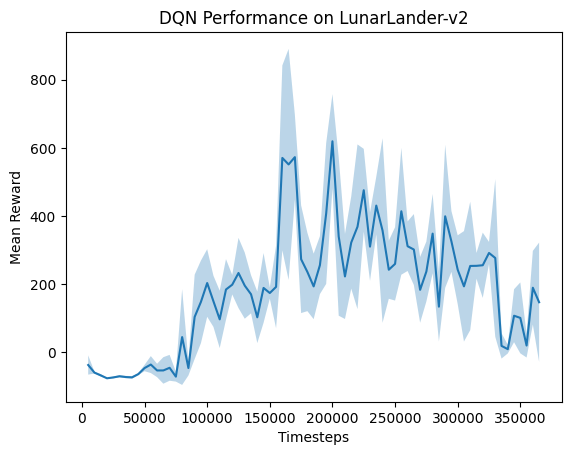

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Load the evaluations.npz file
data = np.load('./logs/evaluations.npz')

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = np.mean(results, axis=1)
std_results = np.std(results, axis=1)

# Plot the results
plt.figure()
plt.plot(timesteps, mean_results)
plt.fill_between(timesteps, mean_results - std_results, mean_results + std_results, alpha=0.3)
plt.xlabel('Timesteps')
plt.ylabel('Mean Reward')
plt.title('DQN Performance on LunarLander-v2')
plt.show()